Saving retail_site_selection_dataset.csv to retail_site_selection_dataset (9).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Store_ID               260 non-null    object 
 1   City                   260 non-null    object 
 2   District               260 non-null    object 
 3   Latitude               260 non-null    float64
 4   Longitude              260 non-null    float64
 5   Area_sqm               260 non-null    float64
 6   Monthly_Rent_mVND      260 non-null    float64
 7   Lease_Start            260 non-null    object 
 8   Lease_End              260 non-null    object 
 9   Foot_Traffic_per_day   260 non-null    int64  
 10  Competitor_Count_500m  260 non-null    int64  
 11  Sales_per_sqm_mVND     260 non-null    float64
 12  Occupancy_Rate         260 non-null    float64
 13  Status                 260 n

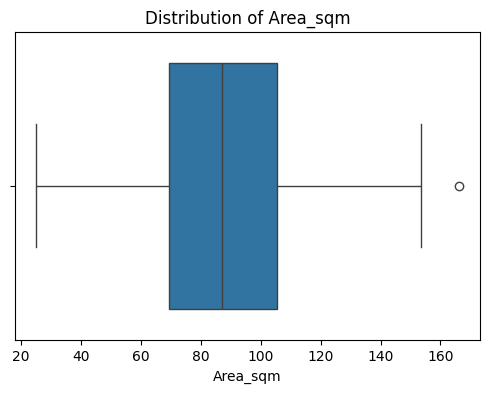

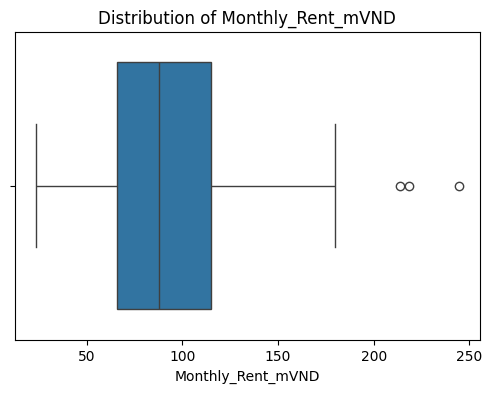

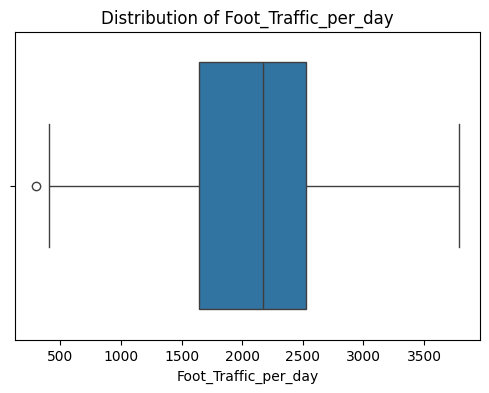

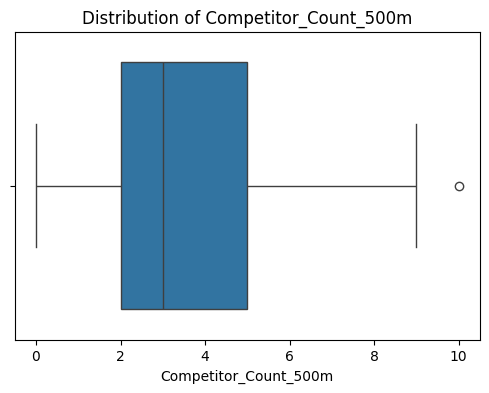

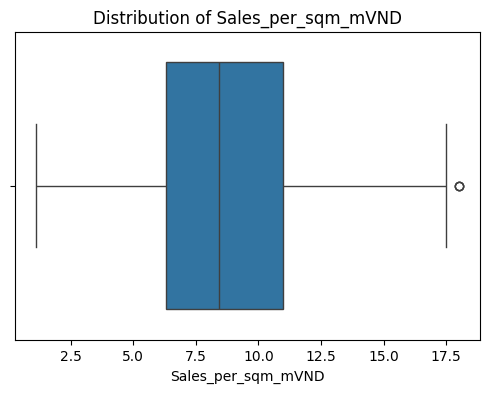

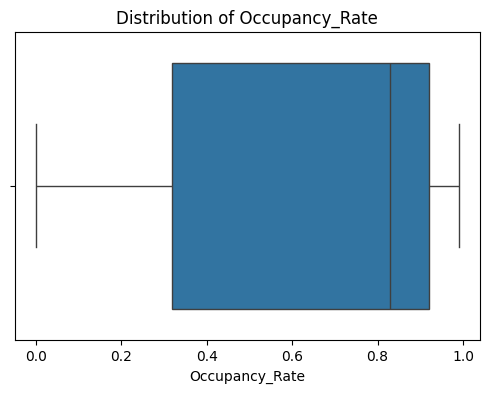

Outlier in Area_sqm
     Area_sqm
193     166.1


Outlier in Monthly_Rent_mVND
     Monthly_Rent_mVND
24              218.28
193             244.45
251             213.78


Outlier in Foot_Traffic_per_day
     Foot_Traffic_per_day
256                   300


Outlier in Competitor_Count_500m
    Competitor_Count_500m
34                     10


Outlier in Sales_per_sqm_mVND
     Sales_per_sqm_mVND
1                  18.0
173                18.0
246                18.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# VERSION 1 - DESCRIPTIVE ANALYSIS
from re import I
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('retail_site_selection_dataset.csv')
df.shape
df.info()
df.isnull().sum()

# Chuyển Lease Start & Lease End vào type Datetime
df['Lease_Start'] = pd.to_datetime(df['Lease_Start'])
df['Lease_End'] = pd.to_datetime(df['Lease_End'])

# Tìm outlier
num_cols = ['Area_sqm', 'Monthly_Rent_mVND', 'Foot_Traffic_per_day', 'Competitor_Count_500m', 'Sales_per_sqm_mVND', 'Occupancy_Rate']
import matplotlib.pyplot as plt
import seaborn as sns
for col in num_cols:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df[col])
  plt.title(f"Distribution of {col}")
  plt.show()

# Lấy danh sách outlier cho từng cột numeric để xem xét loại hay giữ
outlier_dict = {}
for col in num_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outlier = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
  if not outlier.empty:
    outlier_dict[col] = outlier[[col]]
    print(f"Outlier in {col}")
    print(outlier[[col]])
    print('\n')
all_outliers = pd.concat(outlier_dict.values(), keys=outlier_dict.keys())

## Sau khi xem xét các outliers, chỉ có outlier 300 ở cột "Foot_Traffic_per_day" là bất hợp lý. Nhưng cần check xem status ở hàng này đang là gì. Nếu Status: Active --> remove outlier tránh ảnh hưởng dữ liệu chung. Nếu Status: Closed thì cần giữ lại để phân tích thêm nguyên nhân đóng cửa
### Check status
status_check = (df['Foot_Traffic_per_day'] == 300)
df.loc[status_check, ['Foot_Traffic_per_day', 'Status']]
## Loại outlier 300 này
index_to_drop = df[(df['Foot_Traffic_per_day'] == 300) & (df['Status'] == 'Active')].index
df.drop(index_to_drop, axis=0, inplace=True)

# Export data
df.to_csv('retail_site_selection_dataset_cleaned.csv', index=False)
files.download('retail_site_selection_dataset_cleaned.csv')

In [15]:
# VERSION 2 - PREDICTIVE ANALYSIS
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('retail_site_selection_dataset_cleaned.csv', low_memory= False)

# I. Data Preparation
## I.1. Remove rows which have status "Closed"
df = df[df['Status'] != 'Closed']
## I.2. Add columns "Total_Sales_mVND" = Sales_per_sqm_mVND * Area_sqm
df['Total_Sales_mVND'] = df['Sales_per_sqm_mVND'] * df['Area_sqm']
## I.3. Add columns "ROI" = (Total_Sales_mVND - 20% * Total_Sales_mVND) / Monthly_Rent_mVND
df['ROI'] = (df['Total_Sales_mVND'] - 0.2 * df['Total_Sales_mVND'] - df['Monthly_Rent_mVND']) / df['Monthly_Rent_mVND']
## II. Predictive Analysis
### II.1. One-hot encoding for Column "City"
df = pd.get_dummies(df, columns= ['City'], drop_first= True)
### II.2. Define & Split x & y
y = df['ROI']
x = df.drop(['Store_ID', 'District', 'Latitude', 'Longitude', 'Area_sqm', 'Monthly_Rent_mVND', 'Lease_Start', 'Lease_End', 'Sales_per_sqm_mVND', 'Total_Sales_mVND', 'ROI', 'Status'], axis= 1)
### II.3. Train/Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)
### II.4. StandardScaler for input columns
from sklearn.preprocessing import StandardScaler
x_num_cols_base = ["Foot_Traffic_per_day", "Competitor_Count_500m", "Occupancy_Rate"]
scaler = StandardScaler()
x_train[x_num_cols_base] = scaler.fit_transform(x_train[x_num_cols_base])
x_test[x_num_cols_base] = scaler.transform(x_test[x_num_cols_base])
### II.5. Modeling
#### II.5.1. Linear Regression + Coeffient
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print('MAE_LR:', mae_lr)
print('RMSE_LR:', rmse_lr)
print('R2 Score_LR:', r2_lr)
print('MAPE_LR:', mape_lr)

coefficients_lr = lr_model.coef_
intercept_lr = lr_model.intercept_
feature_name_lr = x_train.columns
coef_df_lr = pd.DataFrame({'Feature': feature_name_lr, 'Coefficient': coefficients_lr}).sort_values(by='Coefficient', ascending=False)
print('Intervept_lr:', intercept_lr)
print(coef_df_lr)

#### II.5.2. Random Forest Regressor + Feature Importances
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators= 100, max_depth= None, min_samples_split= 2, min_samples_leaf= 1, random_state= 42, n_jobs= -1).fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print('MAE_RF:', mae_rf)
print('RMSE_RF:', rmse_rf)
print('R2 Score_RF:', r2_rf)
print('MAPE_RF:', mape_rf)


feat_importances_rf = pd.DataFrame({'Feature': x_train.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feat_importances_rf)

#### II.5.3. XGB Regressor
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators= 200, max_depth= 6, subsample= 1.0, colsample_bytree= 1.0, random_state= 42, n_jobs= -1, tree_method= 'hist').fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print('MAE_XGB:', mae_xgb)
print('RMSE_XGB:', rmse_xgb)
print('R2 Score_XGB:', r2_xgb)
print('MAPE_XGB:', mape_xgb)

## II.6. Feature Engineering
### II.6.1. Add Column "Traffic_per_sqm" = Foot_Traffic_per_day / Area_sqm
df['Traffic_per_sqm'] = df['Foot_Traffic_per_day'] / df['Area_sqm']
### II.6.2. Add Column "Rent_per_sqm" = Monthly_Rent_mVND / Area_sqm
df['Rent_per_sqm'] = df['Monthly_Rent_mVND'] / df['Area_sqm']
### II.6.3. Add Column "Lease_Term" = Lease_End - Lease_Start
df['Lease_Start'] = pd.to_datetime(df['Lease_Start'])
df['Lease_End'] = pd.to_datetime(df['Lease_End'])
df['Lease_Term'] = (df['Lease_End'] - df['Lease_Start']).dt.days / 30
### II.6.4. Split x & y
y = df['ROI']
x = df.drop(['Store_ID', 'District', 'Latitude', 'Longitude', 'Area_sqm', 'Monthly_Rent_mVND', 'Lease_Start', 'Lease_End', 'Sales_per_sqm_mVND', 'Total_Sales_mVND', 'ROI', 'Status'], axis= 1)
### II.6.5. Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)
### II.6.6. StandardScaler for input numeric columns
x_num_cols_fe = ["Foot_Traffic_per_day", "Competitor_Count_500m", "Occupancy_Rate", "Traffic_per_sqm", "Rent_per_sqm", "Lease_Term"]
scaler = StandardScaler()
x_train[x_num_cols_fe] = scaler.fit_transform(x_train[x_num_cols_fe])
x_test[x_num_cols_fe] = scaler.transform(x_test[x_num_cols_fe])
import joblib
joblib.dump(scaler, "scaler_v2.pkl")
### II.6.7. Remodeling
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print('MAE_LR:', mae_lr)
print('RMSE_LR:', rmse_lr)
print('R2 Score_LR:', r2_lr)
print('MAPE_LR:', mape_lr)
coefficients_lr = lr_model.coef_
intercept_lr = lr_model.intercept_
feature_name_lr = x_train.columns
coef_df_lr = pd.DataFrame({'Feature': feature_name_lr, 'Coefficient': coefficients_lr}).sort_values(by='Coefficient', ascending=False)
print('Intervept_lr:', intercept_lr)
print(coef_df_lr)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators= 100, max_depth= None, min_samples_split= 2, min_samples_leaf= 1, random_state= 42, n_jobs= -1).fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print('MAE_RF:', mae_rf)
print('RMSE_RF:', rmse_rf)
print('R2 Score_RF:', r2_rf)
print('MAPE_RF:', mape_rf)
feat_importances_rf = pd.DataFrame({'Feature': x_train.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feat_importances_rf)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators= 200, max_depth= 6, subsample= 1.0, colsample_bytree= 1.0, random_state= 42, n_jobs= -1, tree_method= 'hist').fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print('MAE_XGB:', mae_xgb)
print('RMSE_XGB:', rmse_xgb)
print('R2 Score_XGB:', r2_xgb)
print('MAPE_XGB:', mape_xgb)
joblib.dump(rf_model, "best_model_v2.pkl")

# Export Data
df.to_csv('retail_site_selection_dataset_cleaned_ver2.csv', index= False)
files.download('retail_site_selection_dataset_cleaned_ver2.csv')

Saving retail_site_selection_dataset_cleaned.csv to retail_site_selection_dataset_cleaned.csv
MAE_LR: 1.928794162363027
RMSE_LR: 2.3887238950481176
R2 Score_LR: 0.39232386275510645
MAPE_LR: 0.7496268237102429
Intervept_lr: 10.540764820921137
                 Feature  Coefficient
0   Foot_Traffic_per_day     2.520209
2         Occupancy_Rate     0.096250
1  Competitor_Count_500m    -0.300416
3            City_DaNang    -1.352298
6          City_HaiPhong    -2.587380
4              City_HCMC    -5.401940
5             City_HaNoi    -5.515707
MAE_RF: 2.0024238714485643
RMSE_RF: 2.4486659664375083
R2 Score_RF: 0.3614434489631555
MAPE_RF: 0.7916265860278214
                 Feature  Importance
0   Foot_Traffic_per_day    0.525072
1  Competitor_Count_500m    0.159625
2         Occupancy_Rate    0.153444
3            City_DaNang    0.057248
4              City_HCMC    0.048649
5             City_HaNoi    0.040864
6          City_HaiPhong    0.015096
MAE_XGB: 2.283528922462851
RMSE_XGB: 2.8360

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# VERSION 3 - DEPLOY MODEL
from google.colab import files
uploaded = files.upload()
import pandas as pd
df_ver2 = pd.read_csv('retail_site_selection_dataset_cleaned_ver2.csv', low_memory= False, index_col= 0)
df_ver3 = pd.read_csv('sales.csv', low_memory= False, index_col=0)

# Calculate new columns or generate values (by mean) if raw data was missing
## Add column ROI
df_ver3['ROI'] = df_ver3['Profit'] / df_ver3['Total Expenses']
## Add column Lease Term
ref_date = pd.to_datetime('01/01/2025')
df_ver3['Date'] = pd.to_datetime(df_ver3['Date'], errors='coerce')
df_ver3['Lease_Term'] = (ref_date - df_ver3['Date']).dt.days / 30
## One-hot Columns State, change name, reduce variable in Column State
df_ver3 = pd.get_dummies(df_ver3, columns=['State'], drop_first=True)
df_ver3 = df_ver3.rename(columns= {'State_Connecticut': 'City_DaNang', 'State_Washington': 'City_HCMC', 'State_Florida': 'City_HaNoi', 'State_Texas': 'City_HaiPhong'})
## Make Foot_Traffic_per_day
df_ver3['Foot_Traffic_per_day'] = df_ver2['Foot_Traffic_per_day'].mean()
df_ver3['Competitor_Count_500m'] = df_ver2['Competitor_Count_500m'].mean()
df_ver3['Occupancy_Rate'] = df_ver2['Occupancy_Rate'].mean()
df_ver3['Area_sqm'] = df_ver2['Area_sqm'].mean()
## Add Column Traffic_per_sqm, Rent_per_sqm
df_ver3['Traffic_per_sqm'] = df_ver3['Foot_Traffic_per_day'] / df_ver3['Area_sqm']
df_ver3['Rent_per_sqm'] = df_ver3['Total Expenses'] / df_ver3['Area_sqm']
df_ver3.columns

# Drop irrelevant columns
x_ver3 = df_ver3.drop(['Market', 'Market Size', 'Profit', 'Margin', 'Sales', 'COGS', 'Total Expenses', 'Marketing', 'Inventory', 'Budget Profit', 'Budget COGS', 'Budget Margin', 'Budget Sales', 'ProductId', 'Date', 'Product Type', 'Product', 'Type','Area_sqm'], axis= 1)
x_ver2 = df_ver2[['Foot_Traffic_per_day', 'Competitor_Count_500m', 'Occupancy_Rate', 'City_DaNang', 'City_HCMC', 'City_HaNoi', 'City_HaiPhong', 'Traffic_per_sqm', 'Rent_per_sqm', 'Lease_Term']]
x_ver3 = x_ver3[x_ver2.columns]
x_ver3.columns
y_ver2 = df_ver2['ROI']
y_ver3 = df_ver3['ROI']

# Reuse the trained Scaler from Version 2
import joblib
x_ver3_num_cols = ["Foot_Traffic_per_day", "Competitor_Count_500m", "Occupancy_Rate", "Traffic_per_sqm", "Rent_per_sqm", "Lease_Term"]
scaler = joblib.load("scaler_v2.pkl")
x_ver3[x_ver3_num_cols] = scaler.transform(x_ver3[x_ver3_num_cols])

# Load the best model from Version 2
model_v2 = joblib.load("best_model_v2.pkl")
y_pred_ver3 = model_v2.predict(x_ver3)
df_ver3["ROI_Predicted"] = y_pred_ver3

# Predict ROI and evaluate results
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
print("R²:", r2_score(y_ver3, y_pred_ver3))
print("MAE:", mean_absolute_error(y_ver3, y_pred_ver3))
print("RMSE:", np.sqrt(mean_squared_error(y_ver3, y_pred_ver3)))

# Export predictive ROI data
df_ver3.to_csv("Predicted_ROI.csv", index=False)
files.download("Predicted_ROI.csv")

Saving retail_site_selection_dataset_cleaned_ver2.csv to retail_site_selection_dataset_cleaned_ver2 (19).csv
Saving sales.csv to sales (19).csv
R²: -36.046351562149496
MAE: 8.214306942101697
RMSE: 8.63170255489186


/tmp/ipython-input-209543323.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ver3['Date'] = pd.to_datetime(df_ver3['Date'], errors='coerce')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>